# Spaceship Titanic
### A kaggle competition
In this notebook we will have a take at the [Spaceship Titanic competition](https://www.kaggle.com/competitions/spaceship-titanic) by Kaggle. 
We are provided with a dataset of fake data about passengers on a spaceship that disappeared in space. Half of its passenger vanished in an other dimension.
We are tasked with predicting the transportation of passengers to an other dimension.  
The data is split in two parts : train and test. The test set has no Transported category. We're supposed to make our predictions on the test set, make a csv of our test predictions and upload it to kaggle, which will evaluate our test predictions and give us a score.

# Table of Contents

## Contents

1. [Imports](#Imports)
2. [Data visualization](#Data-visualization)
3. [Feature engineering](#Feature-engineering)
4. [Feature selection](#Feature-selection)
5. [Encoding feature values](#Encoding-feature-values)
6. [Imputing NaN values](#Imputing-NaN-values)
7. [Modeling](#Modeling)
8. [Results](#Results)

# Imports

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from scipy.stats import zscore
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score, ShuffleSplit, RandomizedSearchCV, RandomizedSearchCV
from sklearn.feature_selection import  chi2, SelectKBest
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score

# Data visualization

We'll first visualize the data before manipulating the data.  
Let's open the dataset. We'll combine both the training and the test data, so that our data manipulations and feature engineering applies to both the datasets.

In [6]:
df = pd.read_csv('train.csv')
df

PassengerId HomePlanet CryoSleep     Cabin    Destination   Age    VIP  \
0        0001_01     Europa     False     B/0/P    TRAPPIST-1e  39.0  False   
1        0002_01      Earth     False     F/0/S    TRAPPIST-1e  24.0  False   
2        0003_01     Europa     False     A/0/S    TRAPPIST-1e  58.0   True   
3        0003_02     Europa     False     A/0/S    TRAPPIST-1e  33.0  False   
4        0004_01      Earth     False     F/1/S    TRAPPIST-1e  16.0  False   
...          ...        ...       ...       ...            ...   ...    ...   
8688     9276_01     Europa     False    A/98/P    55 Cancri e  41.0   True   
8689     9278_01      Earth      True  G/1499/S  PSO J318.5-22  18.0  False   
8690     9279_01      Earth     False  G/1500/S    TRAPPIST-1e  26.0  False   
8691     9280_01     Europa     False   E/608/S    55 Cancri e  32.0  False   
8692     9280_02     Europa     False   E/608/S    TRAPPIST-1e  44.0  False   

      RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  \
0             0.0        0.0           0.0     0.0     0.0    Maham Ofracculy   
1           109.0        9.0          25.0   549.0    44.0       Juanna Vines   
2            43.0     3576.0           0.0  6715.0    49.0      Altark Susent   
3             0.0     1283.0         371.0  3329.0   193.0       Solam Susent   
4           303.0       70.0         151.0   565.0     2.0  Willy Santantines   
...           ...        ...           ...     ...     ...                ...   
8688          0.0     6819.0           0.0  1643.0    74.0  Gravior Noxnuther   
8689          0.0        0.0           0.0     0.0     0.0    Kurta Mondalley   
8690          0.0        0.0        1872.0     1.0     0.0       Fayey Connon   
8691          0.0     1049.0           0.0   353.0  3235.0   Celeon Hontichre   
8692        126.0     4688.0           0.0     0.0    12.0   Propsh Hontichre   

      Transported  
0           False  
1            True  
2           False  
3           False  
4            True  
...           ...  
8688        False  
8689        False  
8690         True  
8691        False  
8692         True  

[8693 rows x 14 columns]

In [7]:
df.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

In [8]:
df.shape

(8693, 14)

In [9]:
df.describe()

Age   RoomService     FoodCourt  ShoppingMall           Spa  \
count  8514.000000   8512.000000   8510.000000   8485.000000   8510.000000   
mean     28.827930    224.687617    458.077203    173.729169    311.138778   
std      14.489021    666.717663   1611.489240    604.696458   1136.705535   
min       0.000000      0.000000      0.000000      0.000000      0.000000   
25%      19.000000      0.000000      0.000000      0.000000      0.000000   
50%      27.000000      0.000000      0.000000      0.000000      0.000000   
75%      38.000000     47.000000     76.000000     27.000000     59.000000   
max      79.000000  14327.000000  29813.000000  23492.000000  22408.000000   

             VRDeck  
count   8505.000000  
mean     304.854791  
std     1145.717189  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%       46.000000  
max    24133.000000

In [10]:
df.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

Let's check the distributions of the transported classes in relation to the features

In [11]:
target_value_counts = df['Transported'].value_counts()
target_value_counts

True     4378
False    4315
Name: Transported, dtype: int64

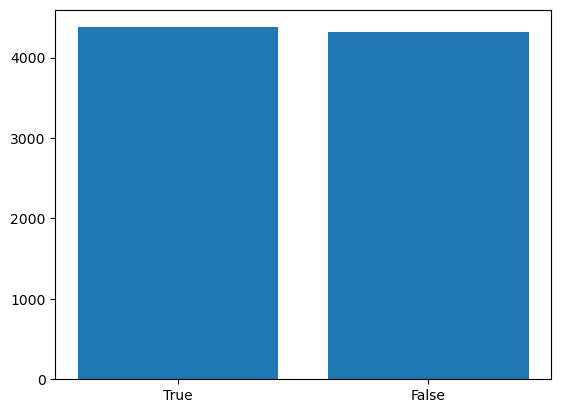

In [12]:
plt.bar(['True', 'False'], target_value_counts)
plt.show()

The count of True and False values are around the same. The target labels are balanced.

We check the number of Transported people according to numerical features

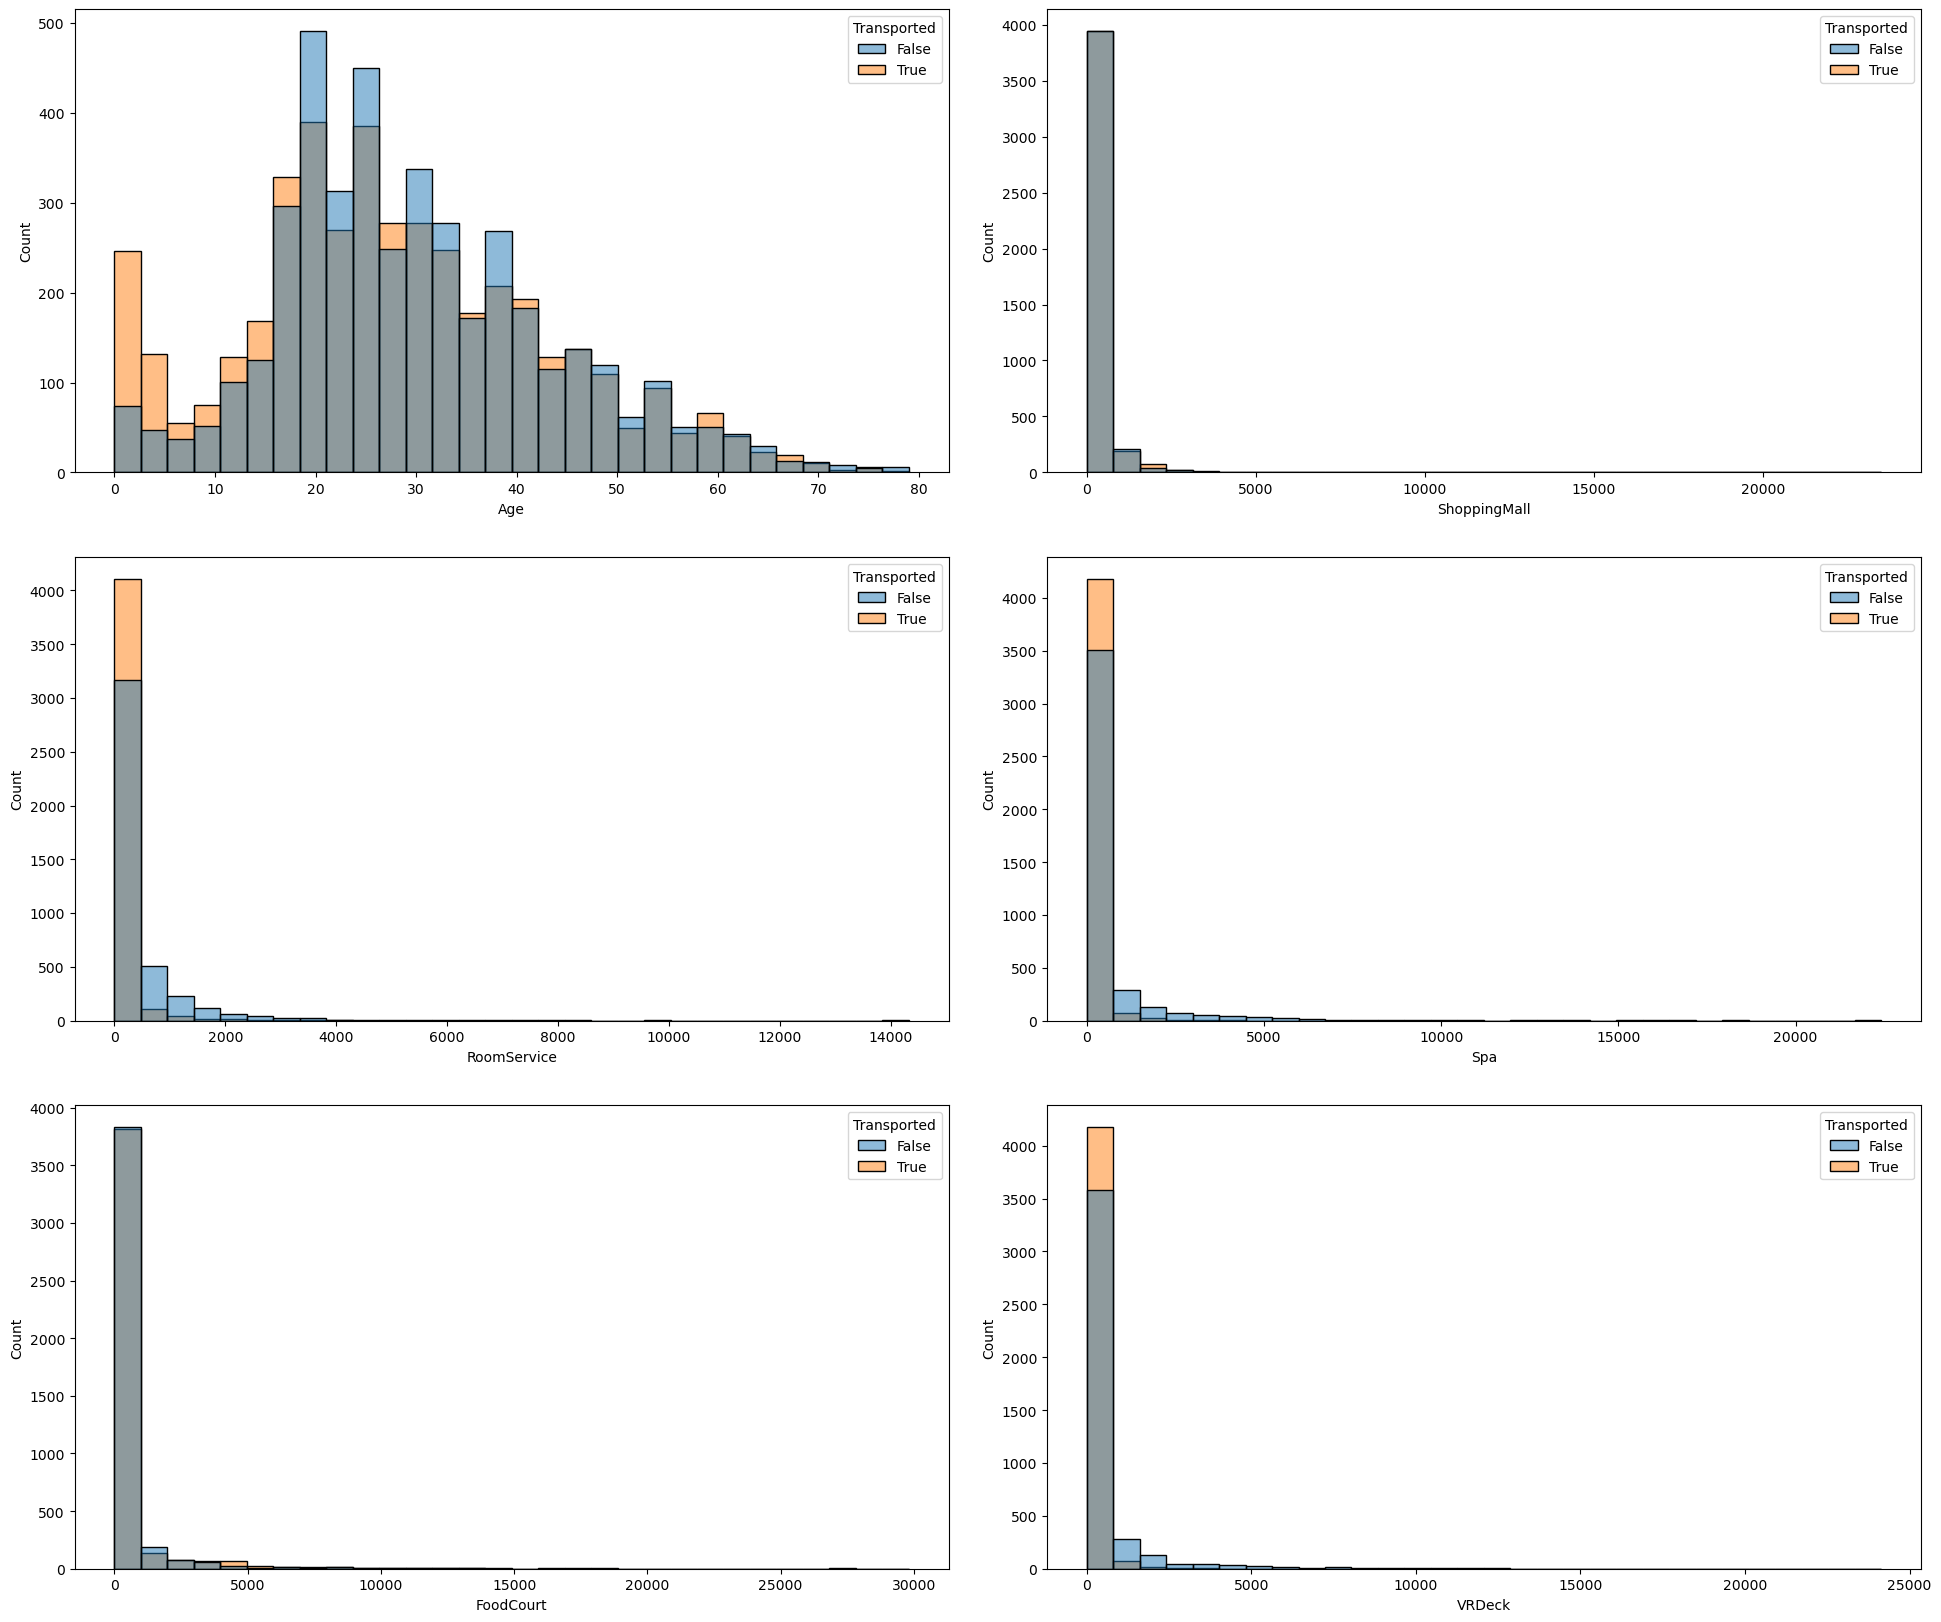

In [13]:
columns = ['Age', 'RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(20,17))
fig.tight_layout(pad=4)
for i,col in enumerate(columns):
    sns.histplot(data=df[[col,'Transported']].dropna(axis=0), x=col, hue="Transported", ax=axs[i%3,i//3], bins=30)
    #pos = df[df['Transported'] == 1][col]
    #neg = df[df['Transported'] == 0][col]
    #axs[i%3,i//3].hist(pos, label="Positive")
    #axs[i%3,i//3].hist(neg, label="Negative")
    #axs[i%3,i//3].legend()
    #axs[i%3,i//3].set_title(col)

plt.show()

We notice that FoodCourt and ShoppingMall share the same distribution, whether or not the person has been transported. So we could try removing that column off of our dataframe.

Now we can clearly see that people who tended to spend more on didn't get transported

<Axes: xlabel='Transported', ylabel='Age'>

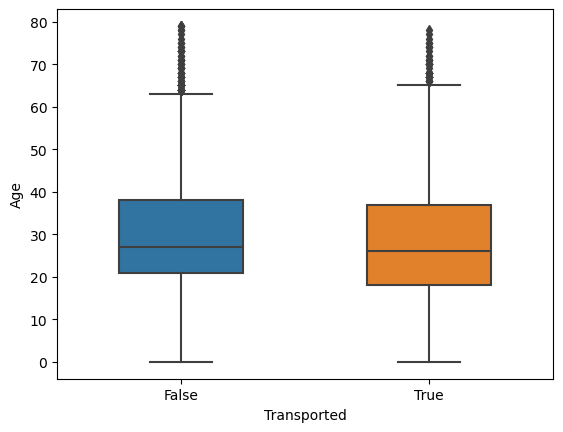

In [14]:
sns.boxplot(data=df[['Age', 'Transported']].dropna(axis=0), y='Age', x='Transported', width=0.5)

Transported people tend to be younger. The quantiles are more spaced.

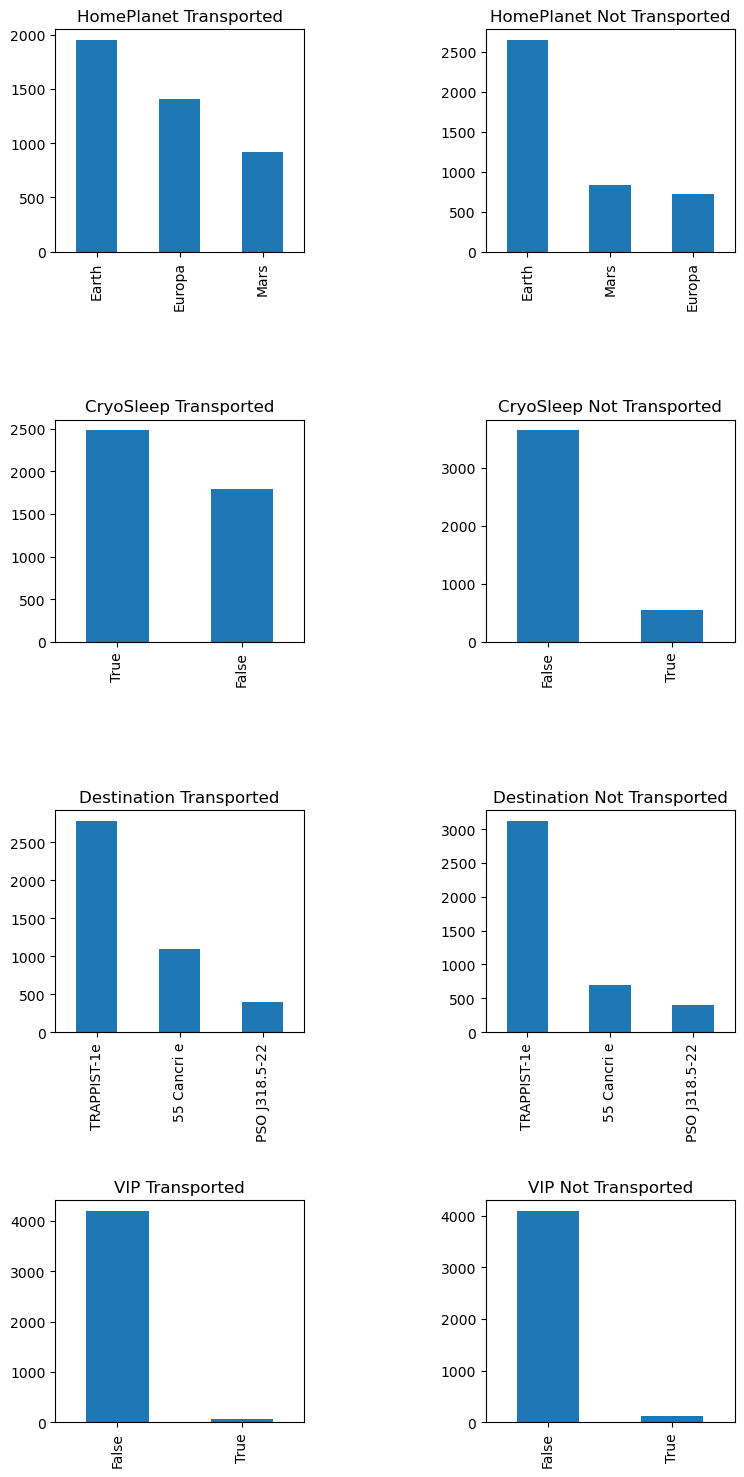

In [15]:
columns = ['HomePlanet','CryoSleep','Destination','VIP']
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(10,17))
fig.tight_layout(pad=10)
for i,col in enumerate(columns):
    axs[i%4,0].set_title(col+" Transported")
    df[df['Transported'] == True][col].value_counts().plot(kind='bar', ax=axs[i%4,0])
    
    axs[i%4,1].set_title(col+" Not Transported")
    df[df['Transported'] == False][col].value_counts().plot(kind='bar', ax=axs[i%4,1])

plt.show()

People in cryosleep were very less likely to be transported  
VIP didn't change the proportions of transported people. Though slightly more Not Transported people were VIP.

# Feature engineering

In [16]:
df.reset_index()

index PassengerId HomePlanet CryoSleep     Cabin    Destination   Age  \
0         0     0001_01     Europa     False     B/0/P    TRAPPIST-1e  39.0   
1         1     0002_01      Earth     False     F/0/S    TRAPPIST-1e  24.0   
2         2     0003_01     Europa     False     A/0/S    TRAPPIST-1e  58.0   
3         3     0003_02     Europa     False     A/0/S    TRAPPIST-1e  33.0   
4         4     0004_01      Earth     False     F/1/S    TRAPPIST-1e  16.0   
...     ...         ...        ...       ...       ...            ...   ...   
8688   8688     9276_01     Europa     False    A/98/P    55 Cancri e  41.0   
8689   8689     9278_01      Earth      True  G/1499/S  PSO J318.5-22  18.0   
8690   8690     9279_01      Earth     False  G/1500/S    TRAPPIST-1e  26.0   
8691   8691     9280_01     Europa     False   E/608/S    55 Cancri e  32.0   
8692   8692     9280_02     Europa     False   E/608/S    TRAPPIST-1e  44.0   

        VIP  RoomService  FoodCourt  ShoppingMall     Spa  VRDeck  \
0     False          0.0        0.0           0.0     0.0     0.0   
1     False        109.0        9.0          25.0   549.0    44.0   
2      True         43.0     3576.0           0.0  6715.0    49.0   
3     False          0.0     1283.0         371.0  3329.0   193.0   
4     False        303.0       70.0         151.0   565.0     2.0   
...     ...          ...        ...           ...     ...     ...   
8688   True          0.0     6819.0           0.0  1643.0    74.0   
8689  False          0.0        0.0           0.0     0.0     0.0   
8690  False          0.0        0.0        1872.0     1.0     0.0   
8691  False          0.0     1049.0           0.0   353.0  3235.0   
8692  False        126.0     4688.0           0.0     0.0    12.0   

                   Name  Transported  
0       Maham Ofracculy        False  
1          Juanna Vines         True  
2         Altark Susent        False  
3          Solam Susent        False  
4     Willy Santantines         True  
...                 ...          ...  
8688  Gravior Noxnuther        False  
8689    Kurta Mondalley        False  
8690       Fayey Connon         True  
8691   Celeon Hontichre        False  
8692   Propsh Hontichre         True  

[8693 rows x 15 columns]

In [17]:
df = df.reset_index().drop('index', axis=1)

In [18]:
df.head()

PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01     Europa     False  B/0/P  TRAPPIST-1e  39.0  False   
1     0002_01      Earth     False  F/0/S  TRAPPIST-1e  24.0  False   
2     0003_01     Europa     False  A/0/S  TRAPPIST-1e  58.0   True   
3     0003_02     Europa     False  A/0/S  TRAPPIST-1e  33.0  False   
4     0004_01      Earth     False  F/1/S  TRAPPIST-1e  16.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  \
0          0.0        0.0           0.0     0.0     0.0    Maham Ofracculy   
1        109.0        9.0          25.0   549.0    44.0       Juanna Vines   
2         43.0     3576.0           0.0  6715.0    49.0      Altark Susent   
3          0.0     1283.0         371.0  3329.0   193.0       Solam Susent   
4        303.0       70.0         151.0   565.0     2.0  Willy Santantines   

   Transported  
0        False  
1         True  
2        False  
3        False  
4         True

In [19]:
df['Group'] = df['PassengerId'].str.split('_', expand=True)[0].astype(str)

In [20]:
df['Cabin']

0          B/0/P
1          F/0/S
2          A/0/S
3          A/0/S
4          F/1/S
          ...   
8688      A/98/P
8689    G/1499/S
8690    G/1500/S
8691     E/608/S
8692     E/608/S
Name: Cabin, Length: 8693, dtype: object

In [21]:
df[['Deck','CabinNumber','Side']] = df['Cabin'].str.split('/', expand=True)

In [22]:
df.head()

PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01     Europa     False  B/0/P  TRAPPIST-1e  39.0  False   
1     0002_01      Earth     False  F/0/S  TRAPPIST-1e  24.0  False   
2     0003_01     Europa     False  A/0/S  TRAPPIST-1e  58.0   True   
3     0003_02     Europa     False  A/0/S  TRAPPIST-1e  33.0  False   
4     0004_01      Earth     False  F/1/S  TRAPPIST-1e  16.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  \
0          0.0        0.0           0.0     0.0     0.0    Maham Ofracculy   
1        109.0        9.0          25.0   549.0    44.0       Juanna Vines   
2         43.0     3576.0           0.0  6715.0    49.0      Altark Susent   
3          0.0     1283.0         371.0  3329.0   193.0       Solam Susent   
4        303.0       70.0         151.0   565.0     2.0  Willy Santantines   

   Transported Group Deck CabinNumber Side  
0        False  0001    B           0    P  
1         True  0002    F           0    S  
2        False  0003    A           0    S  
3        False  0003    A           0    S  
4         True  0004    F           1    S

In [23]:
df['CabinNumber'] = df['CabinNumber'].astype(int, errors='ignore')

In [24]:
df['LastName'] = df['Name'].str.split(' ', expand=True)[1]

In [25]:
df.shape

(8693, 19)

In [26]:
df.set_index('PassengerId', inplace=True)

In [27]:
df.head()

HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
PassengerId                                                         
0001_01         Europa     False  B/0/P  TRAPPIST-1e  39.0  False   
0002_01          Earth     False  F/0/S  TRAPPIST-1e  24.0  False   
0003_01         Europa     False  A/0/S  TRAPPIST-1e  58.0   True   
0003_02         Europa     False  A/0/S  TRAPPIST-1e  33.0  False   
0004_01          Earth     False  F/1/S  TRAPPIST-1e  16.0  False   

             RoomService  FoodCourt  ShoppingMall     Spa  VRDeck  \
PassengerId                                                         
0001_01              0.0        0.0           0.0     0.0     0.0   
0002_01            109.0        9.0          25.0   549.0    44.0   
0003_01             43.0     3576.0           0.0  6715.0    49.0   
0003_02              0.0     1283.0         371.0  3329.0   193.0   
0004_01            303.0       70.0         151.0   565.0     2.0   

                          Name  Transported Group Deck CabinNumber Side  \
PassengerId                                                               
0001_01        Maham Ofracculy        False  0001    B           0    P   
0002_01           Juanna Vines         True  0002    F           0    S   
0003_01          Altark Susent        False  0003    A           0    S   
0003_02           Solam Susent        False  0003    A           0    S   
0004_01      Willy Santantines         True  0004    F           1    S   

                LastName  
PassengerId               
0001_01        Ofracculy  
0002_01            Vines  
0003_01           Susent  
0003_02           Susent  
0004_01      Santantines

In [28]:
df.dtypes

HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
Group            object
Deck             object
CabinNumber      object
Side             object
LastName         object
dtype: object

We'll also count the number of people in each group and the number of family members

In [29]:
n_group_members = df['Group'].value_counts().reset_index()
n_group_members.columns = ['Group', 'N_group_members']
n_group_members

Group  N_group_members
0     4256                8
1     5133                8
2     8956                8
3     8168                8
4     0984                8
...    ...              ...
6212  3469                1
6213  3468                1
6214  3467                1
6215  3465                1
6216  3491                1

[6217 rows x 2 columns]

In [30]:
n_family_members = df['LastName'].value_counts().reset_index()
n_family_members.columns = ['LastName', 'N_family_members']
n_family_members

LastName  N_family_members
0     Casonston                18
1       Oneiles                16
2     Domington                15
3      Litthews                15
4        Cartez                14
...         ...               ...
2212  Ofracculy                 1
2213  Clutcheed                 1
2214       Bota                 1
2215     Rupent                 1
2216  Conablese                 1

[2217 rows x 2 columns]

In [31]:
df

HomePlanet CryoSleep     Cabin    Destination   Age    VIP  \
PassengerId                                                              
0001_01         Europa     False     B/0/P    TRAPPIST-1e  39.0  False   
0002_01          Earth     False     F/0/S    TRAPPIST-1e  24.0  False   
0003_01         Europa     False     A/0/S    TRAPPIST-1e  58.0   True   
0003_02         Europa     False     A/0/S    TRAPPIST-1e  33.0  False   
0004_01          Earth     False     F/1/S    TRAPPIST-1e  16.0  False   
...                ...       ...       ...            ...   ...    ...   
9276_01         Europa     False    A/98/P    55 Cancri e  41.0   True   
9278_01          Earth      True  G/1499/S  PSO J318.5-22  18.0  False   
9279_01          Earth     False  G/1500/S    TRAPPIST-1e  26.0  False   
9280_01         Europa     False   E/608/S    55 Cancri e  32.0  False   
9280_02         Europa     False   E/608/S    TRAPPIST-1e  44.0  False   

             RoomService  FoodCourt  ShoppingMall     Spa  VRDeck  \
PassengerId                                                         
0001_01              0.0        0.0           0.0     0.0     0.0   
0002_01            109.0        9.0          25.0   549.0    44.0   
0003_01             43.0     3576.0           0.0  6715.0    49.0   
0003_02              0.0     1283.0         371.0  3329.0   193.0   
0004_01            303.0       70.0         151.0   565.0     2.0   
...                  ...        ...           ...     ...     ...   
9276_01              0.0     6819.0           0.0  1643.0    74.0   
9278_01              0.0        0.0           0.0     0.0     0.0   
9279_01              0.0        0.0        1872.0     1.0     0.0   
9280_01              0.0     1049.0           0.0   353.0  3235.0   
9280_02            126.0     4688.0           0.0     0.0    12.0   

                          Name  Transported Group Deck CabinNumber Side  \
PassengerId                                                               
0001_01        Maham Ofracculy        False  0001    B           0    P   
0002_01           Juanna Vines         True  0002    F           0    S   
0003_01          Altark Susent        False  0003    A           0    S   
0003_02           Solam Susent        False  0003    A           0    S   
0004_01      Willy Santantines         True  0004    F           1    S   
...                        ...          ...   ...  ...         ...  ...   
9276_01      Gravior Noxnuther        False  9276    A          98    P   
9278_01        Kurta Mondalley        False  9278    G        1499    S   
9279_01           Fayey Connon         True  9279    G        1500    S   
9280_01       Celeon Hontichre        False  9280    E         608    S   
9280_02       Propsh Hontichre         True  9280    E         608    S   

                LastName  
PassengerId               
0001_01        Ofracculy  
0002_01            Vines  
0003_01           Susent  
0003_02           Susent  
0004_01      Santantines  
...                  ...  
9276_01        Noxnuther  
9278_01        Mondalley  
9279_01           Connon  
9280_01        Hontichre  
9280_02        Hontichre  

[8693 rows x 18 columns]

In [32]:
df = df.reset_index().merge(n_family_members, how = 'left', on = ['LastName'])
df = df.merge(n_group_members, how = 'left', on = ['Group'])
df = df.set_index('PassengerId')
df

HomePlanet CryoSleep     Cabin    Destination   Age    VIP  \
PassengerId                                                              
0001_01         Europa     False     B/0/P    TRAPPIST-1e  39.0  False   
0002_01          Earth     False     F/0/S    TRAPPIST-1e  24.0  False   
0003_01         Europa     False     A/0/S    TRAPPIST-1e  58.0   True   
0003_02         Europa     False     A/0/S    TRAPPIST-1e  33.0  False   
0004_01          Earth     False     F/1/S    TRAPPIST-1e  16.0  False   
...                ...       ...       ...            ...   ...    ...   
9276_01         Europa     False    A/98/P    55 Cancri e  41.0   True   
9278_01          Earth      True  G/1499/S  PSO J318.5-22  18.0  False   
9279_01          Earth     False  G/1500/S    TRAPPIST-1e  26.0  False   
9280_01         Europa     False   E/608/S    55 Cancri e  32.0  False   
9280_02         Europa     False   E/608/S    TRAPPIST-1e  44.0  False   

             RoomService  FoodCourt  ShoppingMall     Spa  VRDeck  \
PassengerId                                                         
0001_01              0.0        0.0           0.0     0.0     0.0   
0002_01            109.0        9.0          25.0   549.0    44.0   
0003_01             43.0     3576.0           0.0  6715.0    49.0   
0003_02              0.0     1283.0         371.0  3329.0   193.0   
0004_01            303.0       70.0         151.0   565.0     2.0   
...                  ...        ...           ...     ...     ...   
9276_01              0.0     6819.0           0.0  1643.0    74.0   
9278_01              0.0        0.0           0.0     0.0     0.0   
9279_01              0.0        0.0        1872.0     1.0     0.0   
9280_01              0.0     1049.0           0.0   353.0  3235.0   
9280_02            126.0     4688.0           0.0     0.0    12.0   

                          Name  Transported Group Deck CabinNumber Side  \
PassengerId                                                               
0001_01        Maham Ofracculy        False  0001    B           0    P   
0002_01           Juanna Vines         True  0002    F           0    S   
0003_01          Altark Susent        False  0003    A           0    S   
0003_02           Solam Susent        False  0003    A           0    S   
0004_01      Willy Santantines         True  0004    F           1    S   
...                        ...          ...   ...  ...         ...  ...   
9276_01      Gravior Noxnuther        False  9276    A          98    P   
9278_01        Kurta Mondalley        False  9278    G        1499    S   
9279_01           Fayey Connon         True  9279    G        1500    S   
9280_01       Celeon Hontichre        False  9280    E         608    S   
9280_02       Propsh Hontichre         True  9280    E         608    S   

                LastName  N_family_members  N_group_members  
PassengerId                                                  
0001_01        Ofracculy               1.0                1  
0002_01            Vines               4.0                1  
0003_01           Susent               6.0                2  
0003_02           Susent               6.0                2  
0004_01      Santantines               6.0                1  
...                  ...               ...              ...  
9276_01        Noxnuther               3.0                1  
9278_01        Mondalley               2.0                1  
9279_01           Connon               6.0                1  
9280_01        Hontichre               6.0                2  
9280_02        Hontichre               6.0                2  

[8693 rows x 20 columns]

We create two more categories that sums the regular spendings and the luxury ones. And one that sums both for the total spendings.

In [33]:
df["Regular"] = df["FoodCourt"] + df["ShoppingMall"] 
df["Luxury"] = df["RoomService"] + df["Spa"] + df["VRDeck"]

In [34]:
df['TotalSpendings'] = df[['Luxury','Regular']].sum(axis=1)
df

HomePlanet CryoSleep     Cabin    Destination   Age    VIP  \
PassengerId                                                              
0001_01         Europa     False     B/0/P    TRAPPIST-1e  39.0  False   
0002_01          Earth     False     F/0/S    TRAPPIST-1e  24.0  False   
0003_01         Europa     False     A/0/S    TRAPPIST-1e  58.0   True   
0003_02         Europa     False     A/0/S    TRAPPIST-1e  33.0  False   
0004_01          Earth     False     F/1/S    TRAPPIST-1e  16.0  False   
...                ...       ...       ...            ...   ...    ...   
9276_01         Europa     False    A/98/P    55 Cancri e  41.0   True   
9278_01          Earth      True  G/1499/S  PSO J318.5-22  18.0  False   
9279_01          Earth     False  G/1500/S    TRAPPIST-1e  26.0  False   
9280_01         Europa     False   E/608/S    55 Cancri e  32.0  False   
9280_02         Europa     False   E/608/S    TRAPPIST-1e  44.0  False   

             RoomService  FoodCourt  ShoppingMall     Spa  ...  Group Deck  \
PassengerId                                                ...               
0001_01              0.0        0.0           0.0     0.0  ...   0001    B   
0002_01            109.0        9.0          25.0   549.0  ...   0002    F   
0003_01             43.0     3576.0           0.0  6715.0  ...   0003    A   
0003_02              0.0     1283.0         371.0  3329.0  ...   0003    A   
0004_01            303.0       70.0         151.0   565.0  ...   0004    F   
...                  ...        ...           ...     ...  ...    ...  ...   
9276_01              0.0     6819.0           0.0  1643.0  ...   9276    A   
9278_01              0.0        0.0           0.0     0.0  ...   9278    G   
9279_01              0.0        0.0        1872.0     1.0  ...   9279    G   
9280_01              0.0     1049.0           0.0   353.0  ...   9280    E   
9280_02            126.0     4688.0           0.0     0.0  ...   9280    E   

             CabinNumber Side     LastName N_family_members N_group_members  \
PassengerId                                                                   
0001_01                0    P    Ofracculy              1.0               1   
0002_01                0    S        Vines              4.0               1   
0003_01                0    S       Susent              6.0               2   
0003_02                0    S       Susent              6.0               2   
0004_01                1    S  Santantines              6.0               1   
...                  ...  ...          ...              ...             ...   
9276_01               98    P    Noxnuther              3.0               1   
9278_01             1499    S    Mondalley              2.0               1   
9279_01             1500    S       Connon              6.0               1   
9280_01              608    S    Hontichre              6.0               2   
9280_02              608    S    Hontichre              6.0               2   

            Regular  Luxury  TotalSpendings  
PassengerId                                  
0001_01         0.0     0.0             0.0  
0002_01        34.0   702.0           736.0  
0003_01      3576.0  6807.0         10383.0  
0003_02      1654.0  3522.0          5176.0  
0004_01       221.0   870.0          1091.0  
...             ...     ...             ...  
9276_01      6819.0  1717.0          8536.0  
9278_01         0.0     0.0             0.0  
9279_01      1872.0     1.0          1873.0  
9280_01      1049.0  3588.0          4637.0  
9280_02      4688.0   138.0          4826.0  

[8693 rows x 23 columns]

Cabin and Name are useless now. So we drop them.

In [35]:
df = df.drop(['Cabin', 'Name'],axis=1)
df

HomePlanet CryoSleep    Destination   Age    VIP  RoomService  \
PassengerId                                                                 
0001_01         Europa     False    TRAPPIST-1e  39.0  False          0.0   
0002_01          Earth     False    TRAPPIST-1e  24.0  False        109.0   
0003_01         Europa     False    TRAPPIST-1e  58.0   True         43.0   
0003_02         Europa     False    TRAPPIST-1e  33.0  False          0.0   
0004_01          Earth     False    TRAPPIST-1e  16.0  False        303.0   
...                ...       ...            ...   ...    ...          ...   
9276_01         Europa     False    55 Cancri e  41.0   True          0.0   
9278_01          Earth      True  PSO J318.5-22  18.0  False          0.0   
9279_01          Earth     False    TRAPPIST-1e  26.0  False          0.0   
9280_01         Europa     False    55 Cancri e  32.0  False          0.0   
9280_02         Europa     False    TRAPPIST-1e  44.0  False        126.0   

             FoodCourt  ShoppingMall     Spa  VRDeck  ...  Group Deck  \
PassengerId                                           ...               
0001_01            0.0           0.0     0.0     0.0  ...   0001    B   
0002_01            9.0          25.0   549.0    44.0  ...   0002    F   
0003_01         3576.0           0.0  6715.0    49.0  ...   0003    A   
0003_02         1283.0         371.0  3329.0   193.0  ...   0003    A   
0004_01           70.0         151.0   565.0     2.0  ...   0004    F   
...                ...           ...     ...     ...  ...    ...  ...   
9276_01         6819.0           0.0  1643.0    74.0  ...   9276    A   
9278_01            0.0           0.0     0.0     0.0  ...   9278    G   
9279_01            0.0        1872.0     1.0     0.0  ...   9279    G   
9280_01         1049.0           0.0   353.0  3235.0  ...   9280    E   
9280_02         4688.0           0.0     0.0    12.0  ...   9280    E   

            CabinNumber Side     LastName N_family_members  N_group_members  \
PassengerId                                                                   
0001_01               0    P    Ofracculy              1.0                1   
0002_01               0    S        Vines              4.0                1   
0003_01               0    S       Susent              6.0                2   
0003_02               0    S       Susent              6.0                2   
0004_01               1    S  Santantines              6.0                1   
...                 ...  ...          ...              ...              ...   
9276_01              98    P    Noxnuther              3.0                1   
9278_01            1499    S    Mondalley              2.0                1   
9279_01            1500    S       Connon              6.0                1   
9280_01             608    S    Hontichre              6.0                2   
9280_02             608    S    Hontichre              6.0                2   

             Regular  Luxury  TotalSpendings  
PassengerId                                   
0001_01          0.0     0.0             0.0  
0002_01         34.0   702.0           736.0  
0003_01       3576.0  6807.0         10383.0  
0003_02       1654.0  3522.0          5176.0  
0004_01        221.0   870.0          1091.0  
...              ...     ...             ...  
9276_01       6819.0  1717.0          8536.0  
9278_01          0.0     0.0             0.0  
9279_01       1872.0     1.0          1873.0  
9280_01       1049.0  3588.0          4637.0  
9280_02       4688.0   138.0          4826.0  

[8693 rows x 21 columns]

In [36]:
df.dtypes

HomePlanet           object
CryoSleep            object
Destination          object
Age                 float64
VIP                  object
RoomService         float64
FoodCourt           float64
ShoppingMall        float64
Spa                 float64
VRDeck              float64
Transported            bool
Group                object
Deck                 object
CabinNumber          object
Side                 object
LastName             object
N_family_members    float64
N_group_members       int64
Regular             float64
Luxury              float64
TotalSpendings      float64
dtype: object

We have many object types in our dataframe. We need to convert these values.  
Let's start by converting the cabin number.

In [37]:
df['CabinNumber'] = df['CabinNumber'].astype(int, errors='ignore')
df['CabinNumber']

PassengerId
0001_01       0
0002_01       0
0003_01       0
0003_02       0
0004_01       1
           ... 
9276_01      98
9278_01    1499
9279_01    1500
9280_01     608
9280_02     608
Name: CabinNumber, Length: 8693, dtype: object

# Feature selection

When we visualized the data. We saw some variables had the same distribution for the same output. So they would not influence the output.

Let's observe the difference of the data distributions between luxury/regular vs services

In [38]:
df.columns

Index(['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'RoomService',
       'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Transported', 'Group',
       'Deck', 'CabinNumber', 'Side', 'LastName', 'N_family_members',
       'N_group_members', 'Regular', 'Luxury', 'TotalSpendings'],
      dtype='object')

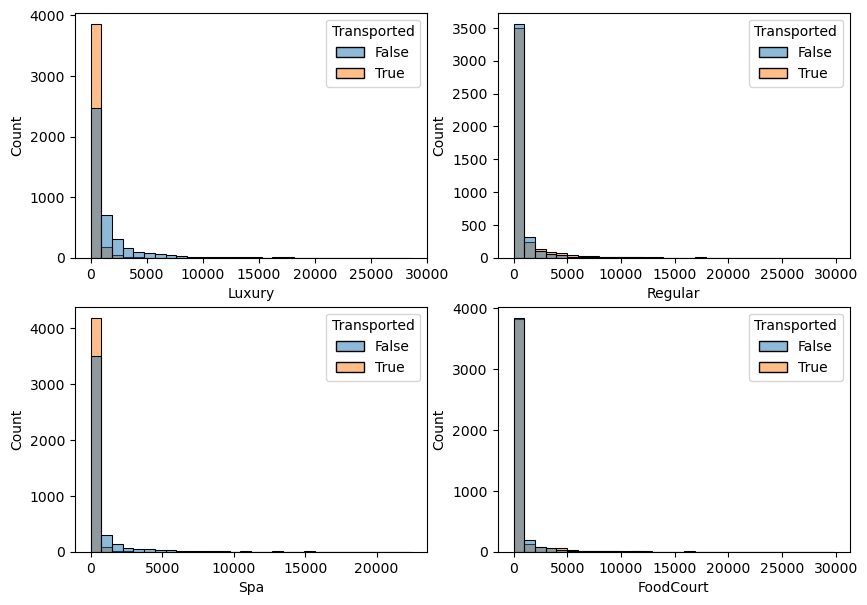

In [39]:
fig, axs = plt.subplots(2,2, figsize=(10,7))
sns.histplot(data=df[['Luxury','Transported']].dropna(axis=0), x='Luxury', hue='Transported', bins=30, ax=axs[0][0])
sns.histplot(data=df[['Regular','Transported']].dropna(axis=0), x='Regular', hue='Transported', bins=30, ax=axs[0][1])
sns.histplot(data=df[['Spa','Transported']].dropna(axis=0), x='Spa', hue='Transported', bins=30, ax=axs[1][0])
sns.histplot(data=df[['FoodCourt','Transported']].dropna(axis=0), x='FoodCourt', hue='Transported', bins=30, ax=axs[1][1])
plt.show()

The differences are more showing when comparing Luxury/Regular spendings vs service by service. As they're combinations of the same data, we can drop the services columns and keep the Luxury/Regular ones.

In [40]:
df = df.drop(["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"], axis=1)

In [41]:
df.columns

Index(['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'Transported',
       'Group', 'Deck', 'CabinNumber', 'Side', 'LastName', 'N_family_members',
       'N_group_members', 'Regular', 'Luxury', 'TotalSpendings'],
      dtype='object')

# Encoding feature values

We will now encode the string values to numerical values, using :
- the LabelEncoder for the label (Transported column)
- the OrdinalEncoder for non numerical values
  
OrdinalEncoder is usually used with data that can be ordered. In my case, because I want to use a RandomForest, I figured I can allow myself to use OrdinalEncoder for every categorical feature.

In [42]:
label_enc = LabelEncoder()
ord_enc = OrdinalEncoder()
oh_enc = OneHotEncoder(drop='first', sparse_output=False)

LabelEncoder encodes Nan values. However we need to keep them, in order to test them at the end. So we'll add an other category that will encode nan as well.

In [43]:
label_enc.fit([True,False])

LabelEncoder()

In [44]:
label_enc.classes_, label_enc.transform(label_enc.classes_)

(array([False,  True]), array([0, 1]))

In [45]:
df = df.apply(lambda series: pd.Series(
    LabelEncoder().fit_transform(series[series.notnull()]),
    index=series[series.notnull()].index
))
df['Transported'].notna().sum(), df['Transported'].isna().sum()

(8693, 0)

Then we'll encode and transform with the ordinal encoder to encode the categorical values into numbers. Because I plan on making a Random Forest, I allow myself to use the ordinal encoder also for unordered values, as they'll just be grouped in each node and compared

In [46]:
df[['HomePlanet','CryoSleep','Destination','LastName','Deck','Side','VIP']] = ord_enc.fit_transform(df[['HomePlanet','CryoSleep','Destination','LastName','Deck','Side','VIP']])

We finally split the dataframe back into the test and train sets.

# Imputing NaN values

In [47]:
df[['TotalSpendings','CryoSleep']].groupby('CryoSleep').value_counts()

CryoSleep  TotalSpendings
0.0        0                  557
           403                 51
           383                 38
           398                 36
           397                 34
                             ... 
           2315                 1
           2316                 1
           2317                 1
           2302                 1
1.0        0                 3037
Length: 2320, dtype: int64

People in CryoSleep couldn't spend money on the starship, so NaN values in the spendings columns will be 0

In [48]:
df[df['Age'] < 13]['TotalSpendings'].sum()

0

Children couldn't spend money either, so it goes the same for them.

In [49]:
df["Luxury"] = np.where((df["Age"] < 13) | (df["CryoSleep"] == True), 0.0, df["Luxury"].astype(float))
df["Regular"] = np.where((df["Age"] < 13) | (df["CryoSleep"] == True), 0.0, df["Regular"].astype(float))
df["TotalSpendings"] = np.where((df["Age"] < 13) | (df["CryoSleep"] == True), 0.0, df["TotalSpendings"].astype(float))
print(df[df['CryoSleep'] == True][['Luxury', 'TotalSpendings', 'Regular']].sum())
print(df[df['Age'] < 13][['Luxury', 'TotalSpendings', 'Regular']].sum())

Luxury            0.0
TotalSpendings    0.0
Regular           0.0
dtype: float64
Luxury            0.0
TotalSpendings    0.0
Regular           0.0
dtype: float64


We also saw that the majority of people didn't spend on Luxury and regular services. So the majority of NaNs should be low in Luxury low in Regular.

We'll now take a look at the distributions of Luxury and Regular features : 

[]

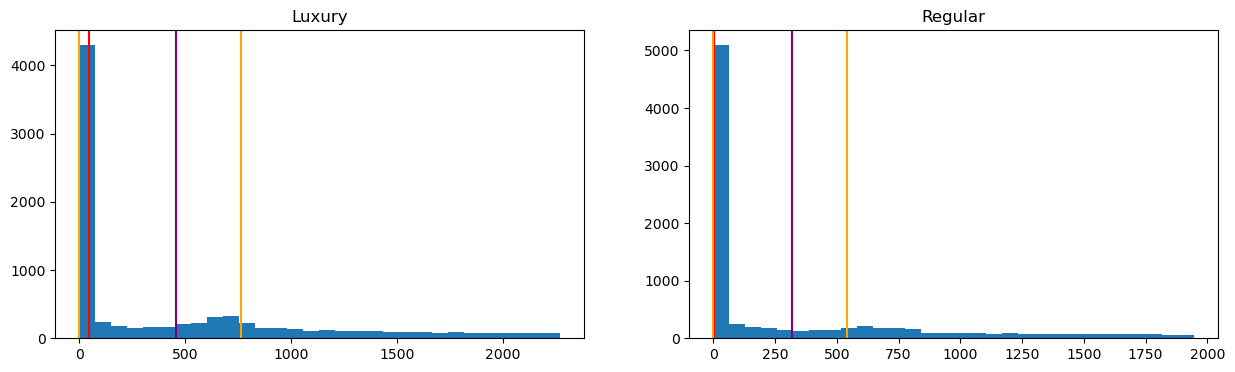

In [50]:
fig, axs = plt.subplots(1, 2, figsize=(15,4))

axs[0].hist(df["Luxury"], bins=30)
axs[0].axvline(df["Luxury"].mean(), c="purple")
axs[0].axvline(df["Luxury"].median(), c="red")
axs[0].axvline(df["Luxury"].quantile(0.25), c="orange")
axs[0].axvline(df["Luxury"].quantile(0.75), c="orange")
axs[0].set_title("Luxury")

axs[1].hist(df["Regular"], bins=30)
axs[1].axvline(df["Regular"].mean(), c="purple")
axs[1].axvline(df["Regular"].median(), c="red")
axs[1].axvline(df["Regular"].quantile(0.25), c="orange")
axs[1].axvline(df["Regular"].quantile(0.75), c="orange")
axs[1].set_title("Regular")

plt.plot()

The issue with these hists is that there is a majority of people in CryoSleep & children that couldn't spend any money. So we shouldn't take them into account.

[]

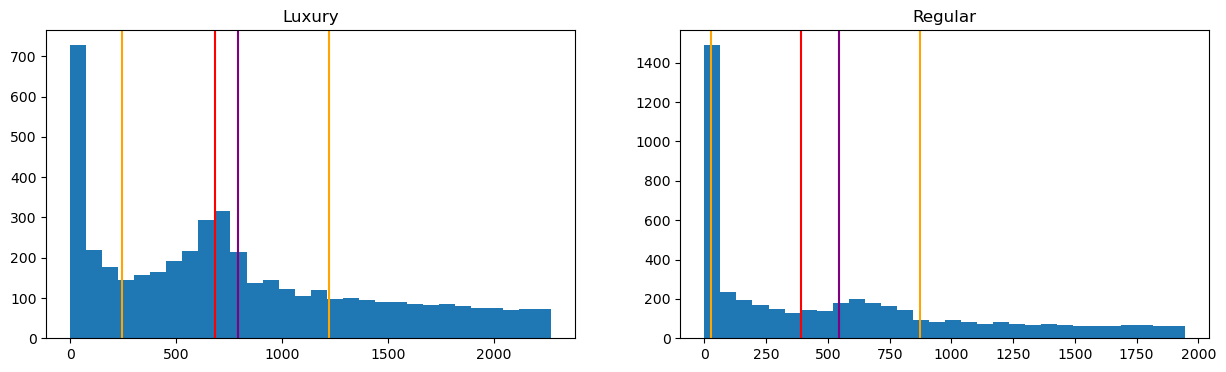

In [51]:
df_money = df[df["CryoSleep"] == False]
df_money = df_money[df_money["Age"] >= 13]

fig, axs = plt.subplots(1, 2, figsize=(15,4))

axs[0].hist(df_money["Luxury"], bins=30)
axs[0].axvline(df_money["Luxury"].mean(), c="purple")
axs[0].axvline(df_money["Luxury"].median(), c="red")
axs[0].axvline(df_money["Luxury"].quantile(0.25), c="orange")
axs[0].axvline(df_money["Luxury"].quantile(0.75), c="orange")
axs[0].set_title("Luxury")

axs[1].hist(df_money["Regular"], bins=30)
axs[1].axvline(df_money["Regular"].mean(), c="purple")
axs[1].axvline(df_money["Regular"].median(), c="red")
axs[1].axvline(df_money["Regular"].quantile(0.25), c="orange")
axs[1].axvline(df_money["Regular"].quantile(0.75), c="orange")
axs[1].set_title("Regular")

plt.plot()

In [52]:
print(f'Luxury spendings of adults mean is {df_money["Luxury"].mean()} and median is {df_money["Luxury"].median()}')
print(f'Regular spendings mean of adults is {df_money["Regular"].mean()} and regular median is {df_money["Regular"].median()}')

Luxury spendings of adults mean is 793.763777825805 and median is 684.0
Regular spendings mean of adults is 543.7213080168776 and regular median is 392.0


Now we see the real distributions of customers on the ship. Let's now plot them according to their Transported status.

[]

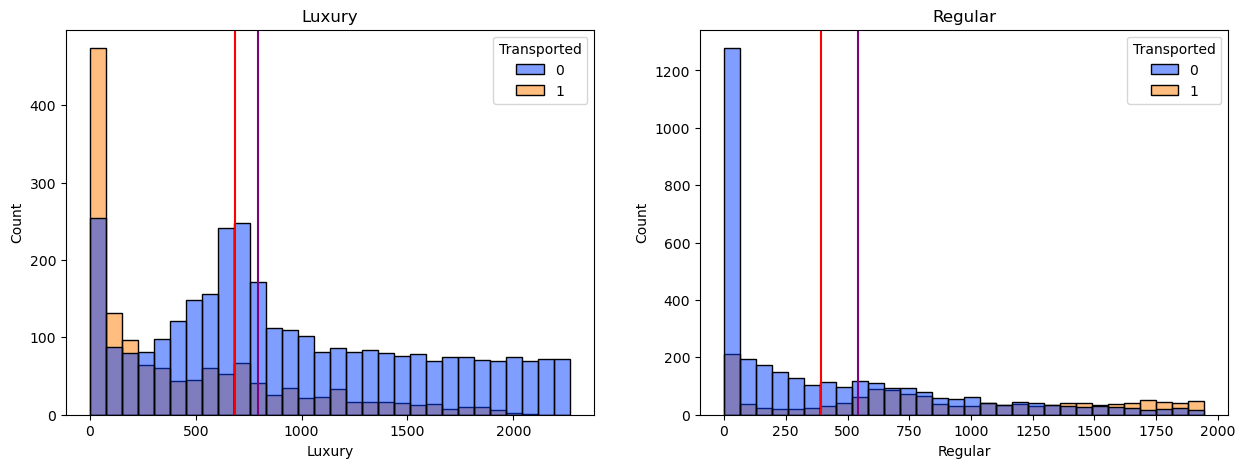

In [53]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
sns.histplot(data=df_money, x="Luxury", hue="Transported", ax=axs[0], bins=30, palette="bright")
sns.histplot(data=df_money, x="Regular", hue="Transported", ax=axs[1], bins=30, palette="bright")

axs[0].axvline(df_money["Luxury"].mean(), c="purple")
axs[0].axvline(df_money["Luxury"].median(), c="red")
axs[0].set_title("Luxury")

axs[1].axvline(df_money["Regular"].mean(), c="purple")
axs[1].axvline(df_money["Regular"].median(), c="red")
axs[1].set_title("Regular")

plt.plot()

80 % of people spent less than 1800€ in luxury services and less than 1350 in regular services. So we should imput NaN values in these columns at these values.  
So it is most likely that people with NaN values in these categories would have a Luxury value between 0 and 1800€ and a regular value between 0 and 1350€

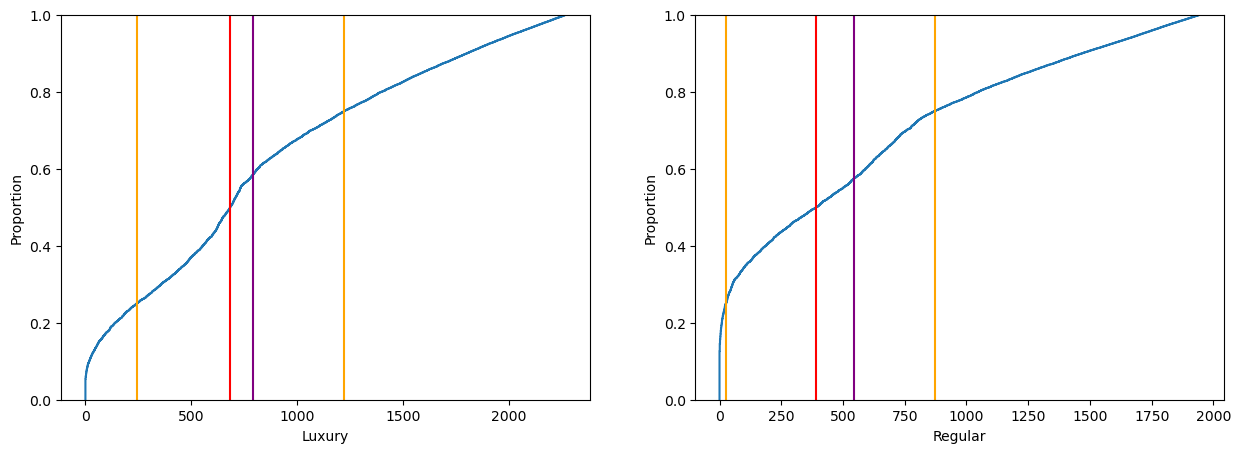

In [54]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
sns.ecdfplot(data=df_money["Luxury"], ax=axs[0])
sns.ecdfplot(data=df_money["Regular"], ax=axs[1])

axs[0].axvline(df_money["Luxury"].mean(), c="purple")
axs[0].axvline(df_money["Luxury"].median(), c="red")
axs[0].axvline(df_money["Luxury"].quantile(0.25), c="orange")
axs[0].axvline(df_money["Luxury"].quantile(0.75), c="orange")

axs[1].axvline(df_money["Regular"].mean(), c="purple")
axs[1].axvline(df_money["Regular"].median(), c="red")
axs[1].axvline(df_money["Regular"].quantile(0.25), c="orange")
axs[1].axvline(df_money["Regular"].quantile(0.75), c="orange")

plt.show()

In [55]:
df_money[['Luxury','Regular']].corr()

Luxury   Regular
Luxury   1.000000 -0.028968
Regular -0.028968  1.000000

In [56]:
df_money[['Luxury','Regular']].cov()

Luxury        Regular
Luxury   403032.644792  -10381.056021
Regular  -10381.056021  315366.598195

Using kNNImputer, we can impute NaN values using the kNN algorithm.

In [57]:
imp = KNNImputer(n_neighbors=5, weights='distance')

In [58]:
cols_wo_class = list(df.columns)
cols_wo_class.remove('Transported')

df[cols_wo_class] = imp.fit_transform(df[cols_wo_class])

We export the dataframe as a csv

In [59]:
df.to_csv('final.csv')

# Modeling

We will now build our random forest, and perform a grid search to find the best parameters for it. I decided to search for optimal values for the max depth, criterion and class weight parameters.

In [54]:
df_test = df[df['Transported'].isna()]
df_train = df[df['Transported'].notna()]
(df_train.shape, df_test.shape)

((8693, 16), (4277, 16))

In [55]:
x_train = df_train.drop('Transported', axis=1)
y_train = df_train['Transported']

In [56]:
df_test = df_test.drop('Transported', axis=1)

## LGBM

In [57]:
from lightgbm import LGBMClassifier

In [58]:
booster = LGBMClassifier(random_state=0, n_jobs=-1)

In [59]:
shuffle = ShuffleSplit(n_splits=10, test_size=0.4)

In [60]:
scores = cross_val_score(booster, x_train, y_train, scoring='accuracy', n_jobs=-1, cv=shuffle)
print(scores)
print(np.mean(scores))

[0.79614721 0.80189764 0.81282346 0.80017251 0.79442208 0.79700978
 0.79298447 0.81052329 0.79528465 0.79902243]
0.8000287521564117


We got 80%. Let's try grid_searching.

In [61]:
gs = GridSearchCV(
    booster,
    {
        "n_estimators":[100,50,10],
        "learning_rate":[0.1, 1e-2, 1e-3],
        "num_leaves":[2,10,30],
        "objective":["binary"]
    },
    scoring="accuracy",
    n_jobs=-1,
    cv=shuffle
)

In [62]:
#This cell takes a minute to run
gs.fit(x_train,y_train)
gs.score(x_train,y_train)

0.8306683538479236

In [63]:
gs.best_params_

{'learning_rate': 0.1,
 'n_estimators': 100,
 'num_leaves': 10,
 'objective': 'binary'}

In [64]:
best_booster = gs.best_estimator_

In [65]:
scores = cross_val_score(booster, x_train, y_train, scoring='accuracy', n_jobs=-1, cv=shuffle)
print(scores)
print(np.mean(scores))

[0.79873491 0.80333525 0.79758482 0.79844738 0.81224842 0.80362277
 0.80161012 0.8013226  0.79442208 0.80448534]
0.8015813686026453


In [66]:
pred = best_booster.predict(df_test)

# Results

We'll now write our results to a csv file and upload it to Kaggle

In [67]:
results = pd.DataFrame(np.vectorize(lambda x:bool(x))(pred), index=df_test.index, columns=['Transported'])
results.to_csv('submission.csv')
results

Transported
PassengerId             
0013_01            False
0018_01            False
0019_01             True
0021_01             True
0023_01            False
...                  ...
9266_02             True
9269_01             True
9271_01             True
9273_01             True
9277_01             True

[4277 rows x 1 columns]

TODO : PCA, FS++, FE++, DNN, RandomizedSearchCV, HalvingSearchCV